In [ ]:
 #hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 1.1 MB/s 
     |████████████████████████████████| 1.2 MB 36.7 MB/s 
     |████████████████████████████████| 197 kB 21.5 MB/s 
     |████████████████████████████████| 60 kB 5.8 MB/s 
Mounted at /content/gdrive


In [ ]:
pip install split-folders

In [ ]:
pip install annoy

     |████████████████████████████████| 646 kB 12.3 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391643 sha256=b4a8e4a9842279893be4e338fca394cea04512870f6a05846266992e0096d9e9
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [ ]:
from annoy import AnnoyIndex
import os
import time
import pickle
import numpy as np
import pandas as pd
from numpy.linalg import norm
from tqdm import tqdm, tqdm_notebook
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
import random
from sklearn.decomposition import PCA
from fastbook import *
from fastai.vision.widgets import *
import csv
import splitfolders
from sklearn.neighbors import NearestNeighbors
import time
from matplotlib.pyplot import imshow, show
%matplotlib inline

In [ ]:
df=pd.read_csv("/content/gdrive/MyDrive/Visual Search Engine/levelshoescategoryv2.csv")

In [ ]:
df

,Unnamed: 0,Product Image,Level 0
0,1,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/0/0/00006a02a04-whtred_1.jpg,WOMEN
1,2,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/0/0/00015a03-tan_1.jpg,WOMEN
2,3,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/0/0/00070a02-white_1.jpg,WOMEN
3,4,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/0/0/001c-tarfle2-cormau_1.jpg,WOMEN
4,5,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/0/1/018473-110_1.jpg,KIDS
...,...,...,...
2409,2410,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/y/h/yhx00012-yb00063-ysa7_1.jpg,KIDS
2410,2411,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/y/l/ylenia-black_1.jpg,WOMEN
2411,2412,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/y/s/ys8-s354-black_1.jpg,WOMEN
2412,2413,https://www.levelshoes.com/media/catalog/product/cache/d7a03fc5ff07250ccf2c7e9bb27ae270/y/s/ys8-s354-lgtblu_1.jpg,WOMEN


In [ ]:
df.columns

Index(['Unnamed: 0', 'Product Image', 'Level 0'], dtype='object')

In [ ]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
uniqueCategory = df['Level 0'].unique()

In [ ]:
uniqueCategory

array(['WOMEN', 'KIDS', 'MEN'], dtype=object)

In [ ]:
for x in uniqueCategory:         ### Looping thru all categories
  mask = df['Level 0'] == x     # selecting specific category
  df2=df[mask]                  #filtering
  producturls=df2['Product Image'].to_numpy()          #converting to array
  download_images("/content/gdrive/MyDrive/Visual Search Engine/Levelshoesdataset/"+x,urls=producturls,max_pics=1000,preserve_filename=True) # utiltizing fastai's image downloadeder and saving different categories in diff folders.

Splitting into Train and Test (80% Train and 20% Test) using Split-Folders Package.

In [ ]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/gdrive/MyDrive/Visual Search Engine/Levelshoesdataset", output="/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 2414 files [00:38, 62.05 files/s]


In [ ]:
#Initialize Model
#model = ResNet50(weights='imagenet', include_top=False, input_shape=(284, 284, 3))

#Define Function to extract Features
def extract_features(img_path, model):
    
    #Preprocessing Input Image
    input_shape = (284, 284, 3)
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1])) #Reshape input image size into target size
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    
    #Getting features from the Image
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1930 [00:00<?, ?it/s]

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/484 [00:00<?, ?it/s]

In [ ]:
pickle.dump(trainingfeature_list, open('trainingfeature_listpickle', 'wb'))
pickle.dump(trainingfilenames, open('trainingfilenamespickle','wb'))

pickle.dump(validationfeature_list, open('validationfeature_listpickle', 'wb'))
pickle.dump(validationfilenames, open('validationfilenamespickle','wb'))

NameError: ignored

In [ ]:
trainingfeature_list = pd.read_pickle(r'/content/gdrive/MyDrive/Visual Search Engine/trainingfeature_listpickle')
trainingfilenames= pd.read_pickle(r'/content/gdrive/MyDrive/Visual Search Engine/trainingfilenamespickle')

In [ ]:
validationfeature_list = pd.read_pickle(r'/content/gdrive/MyDrive/Visual Search Engine/validationfeature_listpickle')
validationfilenames= pd.read_pickle(r'/content/gdrive/MyDrive/Visual Search Engine/validationfilenamespickle')

In [ ]:
len(trainingfeature_list)

1930

In [ ]:
len(trainingfilenames)

1930

In [ ]:
len(validationfeature_list)

484

In [ ]:
len(validationfilenames)

484

In [ ]:
def classname(str):
    return str.split('/')[-2]

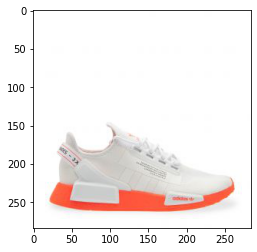

827


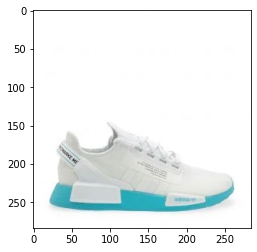

832


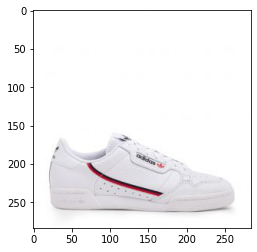

668


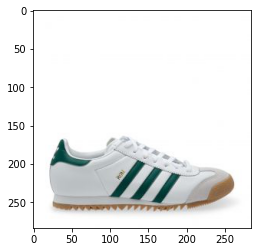

459


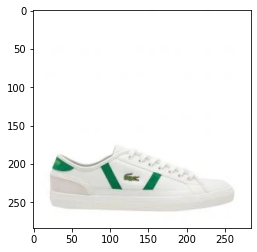

504


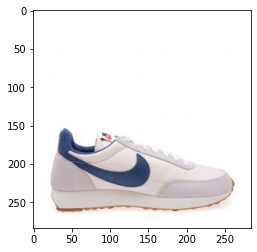

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',
metric='euclidean').fit(trainingfeature_list)
test_num = 200
distances, indices = neighbors.kneighbors([validationfeature_list[test_num]])
result = indices.flatten()
plt.imshow(mpimg.imread(validationfilenames[test_num]))
show()
for i in result:
  print(i)
  plt.imshow(mpimg.imread(trainingfilenames[i]))
  show()

In [ ]:
def calculate_confusionmatrix(trainfeature_list,valfeature_list):
    num_nearest_neighbors = 5
    y_true=[]
    y_pred=[]
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(trainfeature_list)         ## Training the KNN on the Training Set 
    
    for i in range(len(valfeature_list)):
        distances, indices = neighbors.kneighbors([valfeature_list[i]])   
        #print(i)           
        for j in range(1, num_nearest_neighbors):
            print(i)
            print("Actual",classname(validationfilenames[i]))
            y_true.append(classname(validationfilenames[i]))
            print("Pred",classname(trainingfilenames[indices[0][j]]))
            y_pred.append(classname(trainingfilenames[indices[0][j]]))
    return y_true,y_pred
    
  

In [ ]:
y_true,y_pred=calculate_confusionmatrix(trainingfeature_list,validationfeature_list)

Streaming output truncated to the last 5000 lines.
Actual KIDS
Pred WOMEN
67
Actual KIDS
Pred MEN
67
Actual KIDS
Pred WOMEN
68
Actual KIDS
Pred KIDS
68
Actual KIDS
Pred KIDS
68
Actual KIDS
Pred WOMEN
68
Actual KIDS
Pred MEN
69
Actual KIDS
Pred KIDS
69
Actual KIDS
Pred KIDS
69
Actual KIDS
Pred MEN
69
Actual KIDS
Pred WOMEN
70
Actual KIDS
Pred KIDS
70
Actual KIDS
Pred KIDS
70
Actual KIDS
Pred MEN
70
Actual KIDS
Pred WOMEN
71
Actual KIDS
Pred MEN
71
Actual KIDS
Pred MEN
71
Actual KIDS
Pred MEN
71
Actual KIDS
Pred MEN
72
Actual MEN
Pred MEN
72
Actual MEN
Pred MEN
72
Actual MEN
Pred WOMEN
72
Actual MEN
Pred MEN
73
Actual MEN
Pred MEN
73
Actual MEN
Pred MEN
73
Actual MEN
Pred MEN
73
Actual MEN
Pred WOMEN
74
Actual MEN
Pred MEN
74
Actual MEN
Pred WOMEN
74
Actual MEN
Pred MEN
74
Actual MEN
Pred MEN
75
Actual MEN
Pred MEN
75
Actual MEN
Pred MEN
75
Actual MEN
Pred MEN
75
Actual MEN
Pred WOMEN
76
Actual MEN
Pred MEN
76
Actual MEN
Pred MEN
76
Actual MEN
Pred MEN
76
Actual MEN
Pred MEN
77
Actual ME

In [ ]:
from sklearn import metrics


# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

NameError: ignored

In [ ]:
annoy_index = AnnoyIndex(165888,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

True

In [ ]:
def calculate_confusionmatrixwithannoy(trainfeature_list,valfeature_list):

    y_true=[]
    y_pred=[]
    incorrect_prediction = 0
    start = time.time()
    for i in range(len(valfeature_list)):
        indices = annoy_index.get_nns_by_vector(valfeature_list[i],5)            
        for j in range(1, 4):
            #print("Actual",classname(validationfilenames[i]))
            y_true.append(classname(validationfilenames[i]))
            #print("Pred",classname(trainingfilenames[indices[j]]))
            y_pred.append(classname(trainingfilenames[indices[j]]))
    end = time.time()        
    return y_true,y_pred,end-start

In [ ]:
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics


# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[133  45  38]
 [ 20 442 159]
 [ 21 147 447]]
              precision    recall  f1-score   support

        KIDS      0.764     0.616     0.682       216
         MEN      0.697     0.712     0.704       621
       WOMEN      0.694     0.727     0.710       615

    accuracy                          0.704      1452
   macro avg      0.719     0.685     0.699      1452
weighted avg      0.706     0.704     0.703      1452



In [ ]:
time

93.08739686012268

In [ ]:
annoy_index = AnnoyIndex(165888,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(40) 

True

In [ ]:
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[133  45  38]
 [ 20 442 159]
 [ 21 147 447]]
              precision    recall  f1-score   support

        KIDS      0.764     0.616     0.682       216
         MEN      0.697     0.712     0.704       621
       WOMEN      0.694     0.727     0.710       615

    accuracy                          0.704      1452
   macro avg      0.719     0.685     0.699      1452
weighted avg      0.706     0.704     0.703      1452



In [ ]:
time

92.24525189399719

In [ ]:
base_model= ResNet50(weights='imagenet', include_top=False, input_shape=(284, 284, 3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
import tensorflow as tf

In [ ]:
inputs = tf.keras.Input(shape=(284, 284, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='softmax')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)    # 3 as output of the classification model
classificationmodel = tf.keras.Model(inputs,x)

In [ ]:
base_learning_rate = 0.0001
classificationmodel.compile(optimizer=tf.keras.10optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=20, width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2
)

In [ ]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory(
                        "/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train",
                        target_size=(284,284),
                        batch_size=32,
                        shuffle=True,
                        seed=123,
                        class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
                        "/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val",
                        target_size=(284,284),
                        batch_size=32,
                        shuffle=False,
                        class_mode='categorical')

Found 1930 images belonging to 3 classes.
Found 484 images belonging to 3 classes.


In [ ]:
num_steps = math.ceil(1930/64)              
classificationmodel.fit_generator(train_generator,
                    steps_per_epoch = num_steps,
                    epochs=10,
                    validation_data = validation_generator,
                    validation_steps = num_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
31/31 [==============================] - 26s 828ms/step - loss: 1.0212 - accuracy: 0.5333
Epoch 2/10
31/31 [==============================] - 26s 813ms/step - loss: 1.0119 - accuracy: 0.5546
Epoch 3/10
31/31 [==============================] - 26s 817ms/step - loss: 1.0013 - accuracy: 0.5505
Epoch 4/10
31/31 [==============================] - 26s 829ms/step - loss: 1.0156 - accuracy: 0.5171
Epoch 5/10
31/31 [==============================] - 26s 838ms/step - loss: 0.9991 - accuracy: 0.5333
Epoch 6/10
31/31 [==============================] - 26s 812ms/step - loss: 1.0019 - accuracy: 0.5278
Epoch 7/10
31/31 [==============================] - 25s 811ms/step - loss: 0.9965 - accuracy: 0.5474
Epoch 8/10
31/31 [==============================] - 26s 830ms/step - loss: 1.0034 - accuracy: 0.5361
Epoch 9/10
31/31 [==============================] - 26s 823ms/step - loss: 0.9912 - accuracy: 0.5494
Epoch 10/10
31/31 [==============================] - 26s 813ms/step - loss: 0.9996 - accura

Optimize for Image Similarity 

In [ ]:
inputs = tf.keras.Input(shape=(284, 284, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)    # 3 as output of the classification model
similaritymodel = tf.keras.Model(inputs,x)

In [ ]:
base_learning_rate = 0.0001
similaritymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
num_steps = math.ceil(1930/64)              
similaritymodel.fit_generator(train_generator,
                    steps_per_epoch = num_steps,
                    epochs=10,
                    validation_data = validation_generator,
                    validation_steps = num_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
31/31 [==============================] - 47s 1s/step - loss: 1.1284 - accuracy: 0.4062 - val_loss: 1.0368 - val_accuracy: 0.4525
Epoch 2/10
31/31 [==============================] - 26s 819ms/step - loss: 0.9986 - accuracy: 0.4940
Epoch 3/10
31/31 [==============================] - 26s 817ms/step - loss: 0.9666 - accuracy: 0.5161
Epoch 4/10
31/31 [==============================] - 26s 837ms/step - loss: 0.9323 - accuracy: 0.5505
Epoch 5/10
31/31 [==============================] - 25s 802ms/step - loss: 0.8644 - accuracy: 0.6031
Epoch 6/10
31/31 [==============================] - 26s 817ms/step - loss: 0.8631 - accuracy: 0.5817
Epoch 7/10
31/31 [==============================] - 25s 798ms/step - loss: 0.8254 - accuracy: 0.6330
Epoch 8/10
31/31 [==============================] - 25s 794ms/step - loss: 0.8275 - accuracy: 0.6227
Epoch 9/10
31/31 [==============================] - 25s 792ms/step - loss: 0.8019 - accuracy: 0.6371
Epoch 10/10
31/31 [==============================] -

In [ ]:
similaritymodel.save('simmodel.h5')

In [ ]:
similaritymodel.layers.pop()

In [ ]:
finalmodel = tf.keras.Model(similaritymodel.input,similaritymodel.layers[-1].output)

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1930 [00:00<?, ?it/s]

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/484 [00:00<?, ?it/s]

In [ ]:
pickle.dump(trainingfeature_list, open('trainingfeature_listpicklefinal', 'wb'))
pickle.dump(trainingfilenames, open('trainingfilenamespicklefinal','wb'))

pickle.dump(validationfeature_list, open('validationfeature_listpicklefinal', 'wb'))
pickle.dump(validationfilenames, open('validationfilenamespicklefinal','wb'))

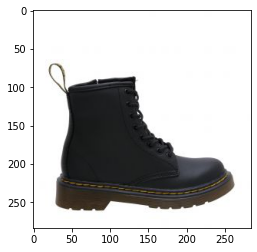

174


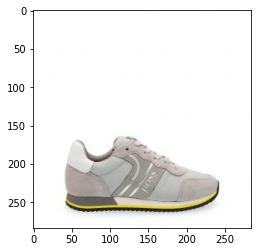

179


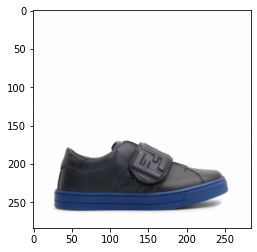

122


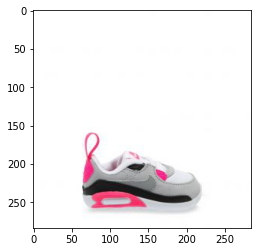

275


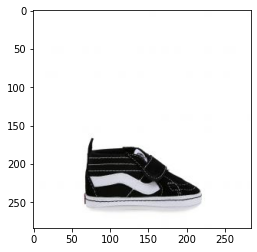

58


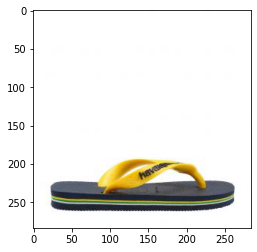

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',
metric='euclidean').fit(trainingfeature_list)
test_num = 9
distances, indices = neighbors.kneighbors([validationfeature_list[test_num]])
result = indices.flatten()
plt.imshow(mpimg.imread(validationfilenames[test_num]))
show()
for i in result:
  print(i)
  plt.imshow(mpimg.imread(trainingfilenames[i]))
  show()

In [ ]:
annoy_index = AnnoyIndex(3,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

True

In [ ]:
def calculate_confusionmatrixwithannoy(trainfeature_list,valfeature_list):

    y_true=[]
    y_pred=[]
    incorrect_prediction = 0
    start = time.time()
    for i in range(len(valfeature_list)):
        indices = annoy_index.get_nns_by_vector(valfeature_list[i],5)            
        for j in range(1, 4):
            #print("Actual",classname(validationfilenames[i]))
            y_true.append(classname(validationfilenames[i]))
            #print("Pred",classname(trainingfilenames[indices[j]]))
            y_pred.append(classname(trainingfilenames[indices[j]]))
    end = time.time()        
    return y_true,y_pred,end-start

In [ ]:
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[100  73  43]
 [ 56 399 166]
 [ 65 178 372]]
              precision    recall  f1-score   support

        KIDS      0.452     0.463     0.458       216
         MEN      0.614     0.643     0.628       621
       WOMEN      0.640     0.605     0.622       615

    accuracy                          0.600      1452
   macro avg      0.569     0.570     0.569      1452
weighted avg      0.601     0.600     0.600      1452



In [ ]:
inputs = tf.keras.Input(shape=(284, 284, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)    # 3 as output of the classification model
similaritymodel = tf.keras.Model(inputs,x)

In [ ]:
base_learning_rate = 0.0001
similaritymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
num_steps = math.ceil(1930/64)              
similaritymodel.fit_generator(train_generator,
                    steps_per_epoch = num_steps,
                    epochs=25,
                    validation_data = validation_generator,
                    validation_steps = num_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
31/31 [==============================] - 215s 7s/step - loss: 1.0856 - accuracy: 0.4254 - val_loss: 0.9708 - val_accuracy: 0.5124
Epoch 2/25
31/31 [==============================] - 72s 2s/step - loss: 1.0106 - accuracy: 0.4990
Epoch 3/25
31/31 [==============================] - 46s 1s/step - loss: 0.9326 - accuracy: 0.5323
Epoch 4/25
31/31 [==============================] - 36s 1s/step - loss: 0.9188 - accuracy: 0.5312
Epoch 5/25
31/31 [==============================] - 30s 942ms/step - loss: 0.8734 - accuracy: 0.5670
Epoch 6/25
31/31 [==============================] - 29s 928ms/step - loss: 0.8470 - accuracy: 0.5918
Epoch 7/25
31/31 [==============================] - 27s 863ms/step - loss: 0.8021 - accuracy: 0.6190
Epoch 8/25
31/31 [==============================] - 26s 845ms/step - loss: 0.8226 - accuracy: 0.6109
Epoch 9/25
31/31 [==============================] - 26s 815ms/step - loss: 0.7816 - accuracy: 0.6423
Epoch 10/25
31/31 [==============================] - 26s 817

In [ ]:
similaritymodel.layers.pop()

In [ ]:
finalmodel = tf.keras.Model(similaritymodel.input,similaritymodel.layers[-1].output)

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1930 [00:00<?, ?it/s]

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/484 [00:00<?, ?it/s]

In [ ]:
annoy_index = AnnoyIndex(3,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

True

In [ ]:
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[ 94  80  42]
 [ 64 382 175]
 [ 38 175 402]]
              precision    recall  f1-score   support

        KIDS      0.480     0.435     0.456       216
         MEN      0.600     0.615     0.607       621
       WOMEN      0.649     0.654     0.652       615

    accuracy                          0.605      1452
   macro avg      0.576     0.568     0.572      1452
weighted avg      0.603     0.605     0.604      1452



In [ ]:
inputs = tf.keras.Input(shape=(284, 284, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)    # 3 as output of the classification model
similaritymodel = tf.keras.Model(inputs,x)

In [ ]:
base_learning_rate = 0.0001
similaritymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
num_steps = math.ceil(1930/64)              
similaritymodel.fit_generator(train_generator,
                    
                    epochs=50,
                    validation_data = validation_generator,
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
61/61 [==============================] - 72s 1s/step - loss: 1.1420 - accuracy: 0.4363 - val_loss: 1.0128 - val_accuracy: 0.5227
Epoch 2/50
61/61 [==============================] - 62s 1s/step - loss: 0.9804 - accuracy: 0.5244 - val_loss: 0.9259 - val_accuracy: 0.5723
Epoch 3/50
61/61 [==============================] - 66s 1s/step - loss: 0.9230 - accuracy: 0.5617 - val_loss: 0.8715 - val_accuracy: 0.6157
Epoch 4/50
61/61 [==============================] - 70s 1s/step - loss: 0.8746 - accuracy: 0.5834 - val_loss: 0.8414 - val_accuracy: 0.6116
Epoch 5/50
61/61 [==============================] - 70s 1s/step - loss: 0.8365 - accuracy: 0.6052 - val_loss: 0.8081 - val_accuracy: 0.6364
Epoch 6/50
61/61 [==============================] - 65s 1s/step - loss: 0.8048 - accuracy: 0.6280 - val_loss: 0.7867 - val_accuracy: 0.6488
Epoch 7/50
61/61 [==============================] - 56s 914ms/step - loss: 0.7860 - accuracy: 0.6326 - val_loss: 0.7790 - val_accuracy: 0.6405
Epoch 8/50
61/61 

In [ ]:
similaritymodel.layers.pop()

In [ ]:
finalmodel = tf.keras.Model(similaritymodel.input,similaritymodel.layers[-1].output)

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1930 [00:00<?, ?it/s]

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/484 [00:00<?, ?it/s]

In [ ]:
annoy_index = AnnoyIndex(3,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

True

In [ ]:
import time
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[140  43  33]
 [ 41 407 173]
 [ 33 141 441]]
              precision    recall  f1-score   support

        KIDS      0.654     0.648     0.651       216
         MEN      0.689     0.655     0.672       621
       WOMEN      0.682     0.717     0.699       615

    accuracy                          0.680      1452
   macro avg      0.675     0.674     0.674      1452
weighted avg      0.681     0.680     0.680      1452



In [ ]:
inputs = tf.keras.Input(shape=(284, 284, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)    # 3 as output of the classification model
similaritymodel = tf.keras.Model(inputs,x)

In [ ]:
base_learning_rate = 0.0001
similaritymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
num_steps = math.ceil(1930/64)              
similaritymodel.fit_generator(train_generator,
                    
                    epochs=100,
                    validation_data = validation_generator,
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/100
61/61 [==============================] - 76s 1s/step - loss: 0.9985 - accuracy: 0.5114 - val_loss: 0.9247 - val_accuracy: 0.5785
Epoch 2/100
61/61 [==============================] - 66s 1s/step - loss: 0.9083 - accuracy: 0.5642 - val_loss: 0.8463 - val_accuracy: 0.6240
Epoch 3/100
61/61 [==============================] - 68s 1s/step - loss: 0.8420 - accuracy: 0.6140 - val_loss: 0.8068 - val_accuracy: 0.6488
Epoch 4/100
61/61 [==============================] - 72s 1s/step - loss: 0.8092 - accuracy: 0.6130 - val_loss: 0.7767 - val_accuracy: 0.6467
Epoch 5/100
61/61 [==============================] - 56s 911ms/step - loss: 0.7848 - accuracy: 0.6358 - val_loss: 0.7576 - val_accuracy: 0.6653
Epoch 6/100
61/61 [==============================] - 56s 916ms/step - loss: 0.7690 - accuracy: 0.6472 - val_loss: 0.7645 - val_accuracy: 0.6364
Epoch 7/100
61/61 [==============================] - 56s 918ms/step - loss: 0.7658 - accuracy: 0.6472 - val_loss: 0.7366 - val_accuracy: 0.6694
Epoc

In [ ]:
similaritymodel.layers.pop()

In [ ]:
finalmodel = tf.keras.Model(similaritymodel.input,similaritymodel.layers[-1].output)

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1930 [00:00<?, ?it/s]

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/484 [00:00<?, ?it/s]

In [ ]:
annoy_index = AnnoyIndex(3,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

True

In [ ]:
import time
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[140  44  32]
 [ 48 422 151]
 [ 21 143 451]]
              precision    recall  f1-score   support

        KIDS      0.670     0.648     0.659       216
         MEN      0.693     0.680     0.686       621
       WOMEN      0.711     0.733     0.722       615

    accuracy                          0.698      1452
   macro avg      0.691     0.687     0.689      1452
weighted avg      0.697     0.698     0.697      1452



In [ ]:
inputs = tf.keras.Input(shape=(284, 284, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)    # 3 as output of the classification model
similaritymodel = tf.keras.Model(inputs,x)

In [ ]:
base_learning_rate = 0.0001
similaritymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
num_steps = math.ceil(1930/64)              
similaritymodel.fit_generator(train_generator,
                    
                    epochs=85,
                    validation_data = validation_generator,validation_steps = num_steps
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/85
61/61 [==============================] - 767s 12s/step - loss: 1.1000 - accuracy: 0.4223 - val_loss: 1.0311 - val_accuracy: 0.4917
Epoch 2/85
61/61 [==============================] - 50s 819ms/step - loss: 0.9608 - accuracy: 0.5244
Epoch 3/85
61/61 [==============================] - 50s 820ms/step - loss: 0.8958 - accuracy: 0.5461
Epoch 4/85
61/61 [==============================] - 49s 798ms/step - loss: 0.8452 - accuracy: 0.5870
Epoch 5/85
61/61 [==============================] - 50s 818ms/step - loss: 0.8034 - accuracy: 0.6244
Epoch 6/85
61/61 [==============================] - 50s 816ms/step - loss: 0.7912 - accuracy: 0.6301
Epoch 7/85
61/61 [==============================] - 50s 809ms/step - loss: 0.7625 - accuracy: 0.6528
Epoch 8/85
61/61 [==============================] - 49s 799ms/step - loss: 0.7401 - accuracy: 0.6596
Epoch 9/85
61/61 [==============================] - 49s 799ms/step - loss: 0.7280 - accuracy: 0.6601
Epoch 10/85
61/61 [==============================]

In [ ]:
similaritymodel.layers.pop()

In [ ]:
finalmodel = tf.keras.Model(similaritymodel.input,similaritymodel.layers[-1].output)

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1930 [00:00<?, ?it/s]

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/484 [00:00<?, ?it/s]

In [ ]:
annoy_index = AnnoyIndex(3,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

True

In [ ]:
import time
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[143  43  30]
 [ 35 430 156]
 [ 20 146 449]]
              precision    recall  f1-score   support

        KIDS      0.722     0.662     0.691       216
         MEN      0.695     0.692     0.694       621
       WOMEN      0.707     0.730     0.718       615

    accuracy                          0.704      1452
   macro avg      0.708     0.695     0.701      1452
weighted avg      0.704     0.704     0.704      1452



In [ ]:
time

1.0397388935089111

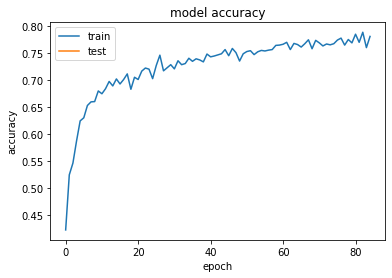

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(similaritymodel.history.history['accuracy'])
plt.plot(similaritymodel.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


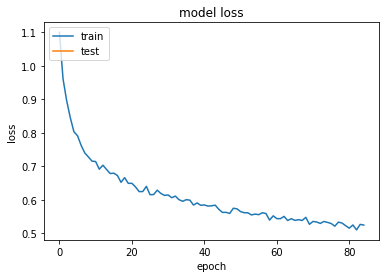

In [ ]:
plt.plot(similaritymodel.history.history['loss'])
plt.plot(similaritymodel.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

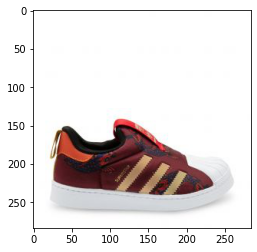

423


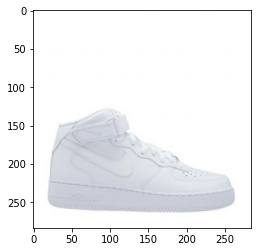

997


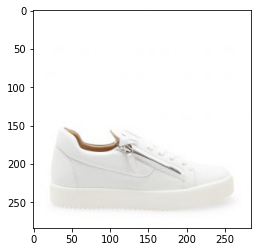

250


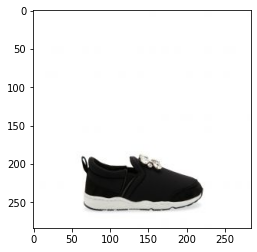

1173


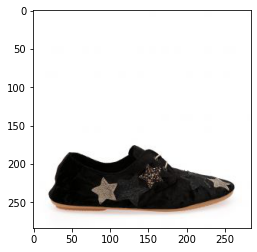

1290


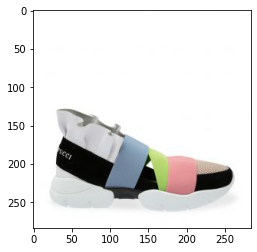

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',
metric='euclidean').fit(trainingfeature_list)
test_num = 34
distances, indices = neighbors.kneighbors([validationfeature_list[test_num]])
result = indices.flatten()
plt.imshow(mpimg.imread(validationfilenames[test_num]))
show()
for i in result:
  print(i)
  plt.imshow(mpimg.imread(trainingfilenames[i]))
  show()

In [ ]:
num_steps = math.ceil(1930/64)              
similaritymodel.fit_generator(train_generator,
                    
                    epochs=85,
                    validation_data = validation_generator
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/85
61/61 [==============================] - 56s 910ms/step - loss: 0.5231 - accuracy: 0.7627 - val_loss: 0.5932 - val_accuracy: 0.7417
Epoch 2/85
61/61 [==============================] - 55s 906ms/step - loss: 0.5206 - accuracy: 0.7715 - val_loss: 0.5953 - val_accuracy: 0.7335
Epoch 3/85
61/61 [==============================] - 54s 890ms/step - loss: 0.5137 - accuracy: 0.7834 - val_loss: 0.5960 - val_accuracy: 0.7314
Epoch 4/85
61/61 [==============================] - 56s 916ms/step - loss: 0.5182 - accuracy: 0.7715 - val_loss: 0.5908 - val_accuracy: 0.7397
Epoch 5/85
61/61 [==============================] - 55s 894ms/step - loss: 0.5194 - accuracy: 0.7813 - val_loss: 0.5996 - val_accuracy: 0.7252
Epoch 6/85
61/61 [==============================] - 54s 888ms/step - loss: 0.5140 - accuracy: 0.7731 - val_loss: 0.6031 - val_accuracy: 0.7231
Epoch 7/85
61/61 [==============================] - 54s 882ms/step - loss: 0.5186 - accuracy: 0.7668 - val_loss: 0.6044 - val_accuracy: 0.7211

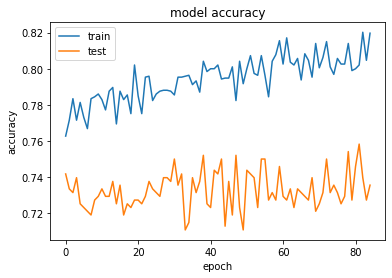

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(similaritymodel.history.history['accuracy'])
plt.plot(similaritymodel.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


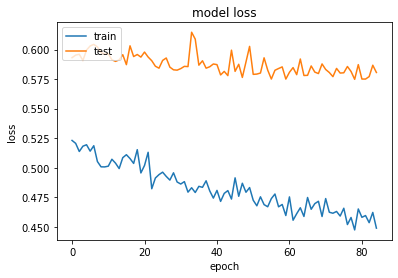

In [ ]:
plt.plot(similaritymodel.history.history['loss'])
plt.plot(similaritymodel.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
similaritymodel.layers.pop()

In [ ]:
finalmodel = tf.keras.Model(similaritymodel.input,similaritymodel.layers[-1].output)

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1930 [00:00<?, ?it/s]

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/484 [00:00<?, ?it/s]

In [ ]:
annoy_index = AnnoyIndex(3,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

True

In [ ]:
import time
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[147  34  35]
 [ 35 458 128]
 [ 23 141 451]]
              precision    recall  f1-score   support

        KIDS      0.717     0.681     0.698       216
         MEN      0.724     0.738     0.730       621
       WOMEN      0.735     0.733     0.734       615

    accuracy                          0.727      1452
   macro avg      0.725     0.717     0.721      1452
weighted avg      0.727     0.727     0.727      1452



In [ ]:
similaritymodel.fit_generator(train_generator,
                    
                    epochs=50,
                    validation_data = validation_generator
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/50
61/61 [==============================] - 67s 1s/step - loss: 0.4655 - accuracy: 0.7938 - val_loss: 0.5817 - val_accuracy: 0.7273
Epoch 2/50
61/61 [==============================] - 61s 999ms/step - loss: 0.4536 - accuracy: 0.8041 - val_loss: 0.5749 - val_accuracy: 0.7397
Epoch 3/50
61/61 [==============================] - 71s 1s/step - loss: 0.4528 - accuracy: 0.8000 - val_loss: 0.5839 - val_accuracy: 0.7293
Epoch 4/50
61/61 [==============================] - 78s 1s/step - loss: 0.4566 - accuracy: 0.8161 - val_loss: 0.5817 - val_accuracy: 0.7438
Epoch 5/50
61/61 [==============================] - 60s 987ms/step - loss: 0.4546 - accuracy: 0.8083 - val_loss: 0.5925 - val_accuracy: 0.7273
Epoch 6/50
61/61 [==============================] - 55s 900ms/step - loss: 0.4549 - accuracy: 0.8088 - val_loss: 0.5762 - val_accuracy: 0.7335
Epoch 7/50
61/61 [==============================] - 56s 909ms/step - loss: 0.4404 - accuracy: 0.8244 - val_loss: 0.5869 - val_accuracy: 0.7231
Epoch 8/

In [ ]:

similaritymodel.layers.pop()

In [ ]:
finalmodel = tf.keras.Model(similaritymodel.input,similaritymodel.layers[-1].output)

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1930 [00:00<?, ?it/s]

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i],finalmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/484 [00:00<?, ?it/s]

In [ ]:
annoy_index = AnnoyIndex(3,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

True

In [ ]:
import time
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[151  38  27]
 [ 30 442 149]
 [ 21 133 461]]
              precision    recall  f1-score   support

        KIDS      0.748     0.699     0.722       216
         MEN      0.721     0.712     0.716       621
       WOMEN      0.724     0.750     0.736       615

    accuracy                          0.726      1452
   macro avg      0.731     0.720     0.725      1452
weighted avg      0.726     0.726     0.726      1452



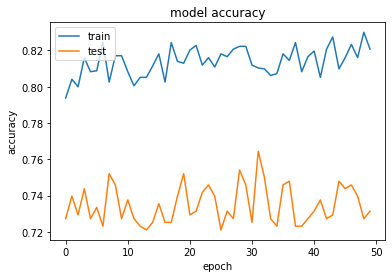

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(similaritymodel.history.history['accuracy'])
plt.plot(similaritymodel.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

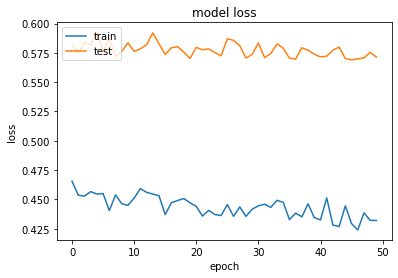

In [ ]:
plt.plot(similaritymodel.history.history['loss'])
plt.plot(similaritymodel.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
base_model=mobilenet = tf.keras.applications.MobileNet(
    input_shape=(284, 284, 3),
    include_top=False,
    weights="imagenet"
)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(284, 284, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)    # 3 as output of the classification model
similaritymodel = tf.keras.Model(inputs,x)

In [ ]:
base_learning_rate = 0.0001
similaritymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
num_steps = math.ceil(1930/64)              
similaritymodel.fit_generator(train_generator,
                  
                    epochs=200,
                    validation_data = validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/200
61/61 [==============================] - 134s 2s/step - loss: 1.0878 - accuracy: 0.4632
Epoch 2/200
61/61 [==============================] - 128s 2s/step - loss: 1.0311 - accuracy: 0.5021
Epoch 3/200
61/61 [==============================] - 127s 2s/step - loss: 1.0128 - accuracy: 0.5135
Epoch 4/200
61/61 [==============================] - 126s 2s/step - loss: 0.9775 - accuracy: 0.5389
Epoch 5/200
61/61 [==============================] - 126s 2s/step - loss: 0.9640 - accuracy: 0.5461
Epoch 6/200
61/61 [==============================] - 126s 2s/step - loss: 0.9441 - accuracy: 0.5627
Epoch 7/200
61/61 [==============================] - 126s 2s/step - loss: 0.9303 - accuracy: 0.5585
Epoch 8/200
61/61 [==============================] - 126s 2s/step - loss: 0.9100 - accuracy: 0.5772
Epoch 9/200
61/61 [==============================] - 126s 2s/step - loss: 0.9028 - accuracy: 0.5658
Epoch 10/200
61/61 [==============================] - 126s 2s/step - loss: 0.8978 - accuracy: 0.5803

In [ ]:
similaritymodel.layers.pop()

In [ ]:
finalmodel = tf.keras.Model(similaritymodel.input,similaritymodel.layers[-1].output)

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i],finalmodel))

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i],finalmodel))

In [ ]:
annoy_index = AnnoyIndex(3,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

In [ ]:
import time
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

Mobilenet

In [ ]:
mobilenet = tf.keras.applications.MobileNet(
    input_shape=(284, 284, 3),
    include_top=False,
    weights="imagenet",
)

NameError: ignored

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i],mobilenet))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1930 [00:00<?, ?it/s]

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i],mobilenet))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/484 [00:00<?, ?it/s]

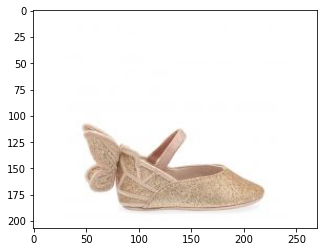

234


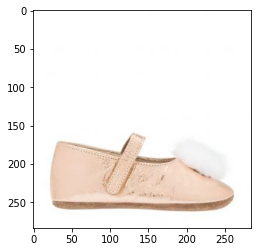

3


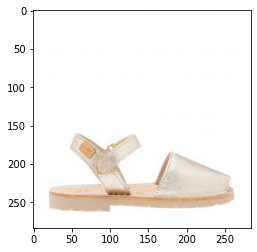

218


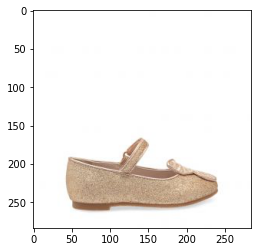

249


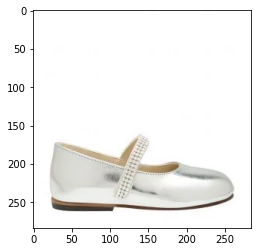

248


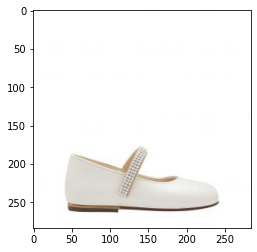

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',
metric='euclidean').fit(trainingfeature_list)
test_num = 47
distances, indices = neighbors.kneighbors([validationfeature_list[test_num]])
result = indices.flatten()
plt.imshow(mpimg.imread(validationfilenames[test_num]))
show()
for i in result:
  print(i)
  plt.imshow(mpimg.imread(trainingfilenames[i]))
  show()

In [ ]:
annoy_index = AnnoyIndex(65536,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

True

In [ ]:
import time

In [ ]:
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[124  51  41]
 [ 43 437 141]
 [ 32 157 426]]
              precision    recall  f1-score   support

        KIDS      0.623     0.574     0.598       216
         MEN      0.678     0.704     0.690       621
       WOMEN      0.701     0.693     0.697       615

    accuracy                          0.680      1452
   macro avg      0.667     0.657     0.662      1452
weighted avg      0.679     0.680     0.679      1452



In [ ]:
time

39.305052280426025

In [ ]:
annoy_index = AnnoyIndex(65536,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(40) 

True

In [ ]:
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[124  51  41]
 [ 43 437 141]
 [ 32 157 426]]
              precision    recall  f1-score   support

        KIDS      0.623     0.574     0.598       216
         MEN      0.678     0.704     0.690       621
       WOMEN      0.701     0.693     0.697       615

    accuracy                          0.680      1452
   macro avg      0.667     0.657     0.662      1452
weighted avg      0.679     0.680     0.679      1452



VGG16

In [ ]:
vggmodel = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(284,284,3),
    
)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i],vggmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1930 [00:00<?, ?it/s]

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i],vggmodel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/484 [00:00<?, ?it/s]

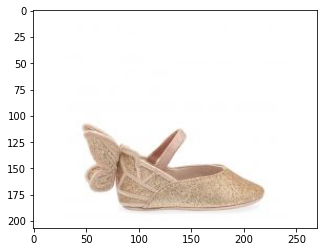

218


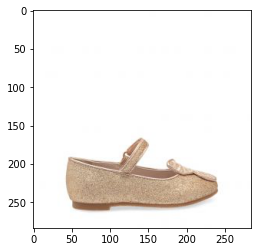

249


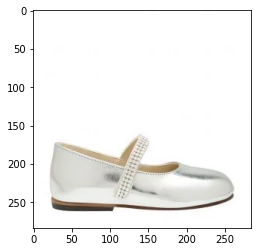

9


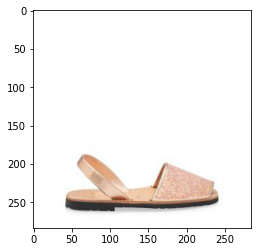

10


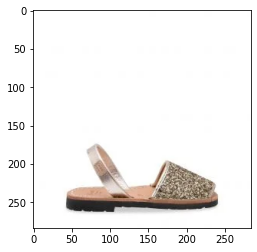

240


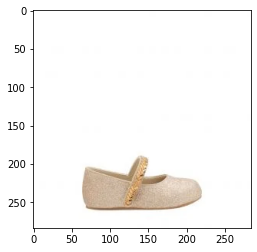

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',
metric='euclidean').fit(trainingfeature_list)
test_num = 47
distances, indices = neighbors.kneighbors([validationfeature_list[test_num]])
result = indices.flatten()
plt.imshow(mpimg.imread(validationfilenames[test_num]))
show()
for i in result:
  print(i)
  plt.imshow(mpimg.imread(trainingfilenames[i]))
  show()

In [ ]:
annoy_index = AnnoyIndex(32768,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000) 

True

In [ ]:
import time

In [ ]:
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
time

16.750479698181152

In [ ]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[126  60  30]
 [ 21 432 168]
 [ 21 151 443]]
              precision    recall  f1-score   support

        KIDS      0.750     0.583     0.656       216
         MEN      0.672     0.696     0.684       621
       WOMEN      0.691     0.720     0.705       615

    accuracy                          0.689      1452
   macro avg      0.704     0.666     0.682      1452
weighted avg      0.692     0.689     0.689      1452



In [ ]:
annoy_index = AnnoyIndex(32768,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(40) 

True

In [ ]:
import time

In [ ]:
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[126  60  30]
 [ 21 432 168]
 [ 21 151 443]]
              precision    recall  f1-score   support

        KIDS      0.750     0.583     0.656       216
         MEN      0.672     0.696     0.684       621
       WOMEN      0.691     0.720     0.705       615

    accuracy                          0.689      1452
   macro avg      0.704     0.666     0.682      1452
weighted avg      0.692     0.689     0.689      1452



In [ ]:
 time

21.866198539733887

In [ ]:
base_model= vggmodel

NameError: ignored

In [ ]:
base_model.trainable = False

In [ ]:
import tensorflow as tf

In [ ]:
inputs = tf.keras.Input(shape=(284, 284, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='softmax')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)    # 3 as output of the classification model
classificationmodel = tf.keras.Model(inputs,x)

In [ ]:
base_learning_rate = 0.0001
classificationmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=20, width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2
)

In [ ]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory(
                        "/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train",
                        target_size=(284,284),
                        batch_size=32,
                        shuffle=True,
                        seed=123,
                        class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
                        "/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val",
                        target_size=(284,284),
                        batch_size=32,
                        shuffle=False,
                        class_mode='categorical')

Found 1930 images belonging to 3 classes.
Found 484 images belonging to 3 classes.


In [ ]:
batch_size=64

In [ ]:
steps_per_epoch = 1930//batch_size

validation_steps = 484//batch_size

In [ ]:
steps_per_epoch

30

In [ ]:
         
classificationmodel.fit_generator(train_generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs=10,
                    validation_data = validation_generator,
                    validation_steps = validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
30/30 [==============================] - 29s 938ms/step - loss: 1.0644 - accuracy: 0.4365
Epoch 2/10
30/30 [==============================] - 26s 857ms/step - loss: 1.0498 - accuracy: 0.4760
Epoch 3/10
30/30 [==============================] - 27s 902ms/step - loss: 1.0508 - accuracy: 0.4424
Epoch 4/10
30/30 [==============================] - 28s 895ms/step - loss: 1.0448 - accuracy: 0.4615
Epoch 5/10
30/30 [==============================] - 26s 839ms/step - loss: 1.0393 - accuracy: 0.5160
Epoch 6/10
30/30 [==============================] - 26s 844ms/step - loss: 1.0301 - accuracy: 0.5192
Epoch 7/10
30/30 [==============================] - 26s 839ms/step - loss: 1.0293 - accuracy: 0.5000
Epoch 8/10
30/30 [==============================] - 26s 850ms/step - loss: 1.0318 - accuracy: 0.4875
Epoch 9/10
30/30 [==============================] - 26s 856ms/step - loss: 1.0320 - accuracy: 0.4625
Epoch 10/10
30/30 [==============================] - 26s 857ms/step - loss: 1.0205 - accura

Optimize for Image Similarity 

In [ ]:
inputs = tf.keras.Input(shape=(284, 284, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)    # 3 as output of the classification model
similaritymodel = tf.keras.Model(inputs,x)

In [ ]:
base_learning_rate = 0.0001
similaritymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
steps_per_epoch = 1930//batch_size

validation_steps = 484//batch_size

In [ ]:
           
similaritymodel.fit_generator(train_generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs=10,
                    validation_data = validation_generator,
                    validation_steps = validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
30/30 [==============================] - 27s 874ms/step - loss: 1.6612 - accuracy: 0.3902
Epoch 2/10
30/30 [==============================] - 26s 841ms/step - loss: 1.5060 - accuracy: 0.4414
Epoch 3/10
30/30 [==============================] - 25s 858ms/step - loss: 1.4675 - accuracy: 0.4499
Epoch 4/10
30/30 [==============================] - 26s 866ms/step - loss: 1.4541 - accuracy: 0.4292
Epoch 5/10
30/30 [==============================] - 26s 856ms/step - loss: 1.3912 - accuracy: 0.4458
Epoch 6/10
30/30 [==============================] - 28s 917ms/step - loss: 1.3661 - accuracy: 0.4760
Epoch 7/10
30/30 [==============================] - 26s 857ms/step - loss: 1.2371 - accuracy: 0.4750
Epoch 8/10
30/30 [==============================] - 26s 837ms/step - loss: 1.2571 - accuracy: 0.4904
Epoch 9/10
30/30 [==============================] - 26s 838ms/step - loss: 1.2514 - accuracy: 0.5117
Epoch 10/10
30/30 [==============================] - 26s 842ms/step - loss: 1.2551 - accura

In [ ]:
similaritymodel.fit_generator(train_generator,
                    
                    epochs=100,
                    validation_data = validation_generator,
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
61/61 [==============================] - 67s 959ms/step - loss: 1.0832 - accuracy: 0.4378 - val_loss: 0.9427 - val_accuracy: 0.5372
Epoch 2/100
61/61 [==============================] - 59s 961ms/step - loss: 0.9702 - accuracy: 0.5078 - val_loss: 0.8646 - val_accuracy: 0.5992
Epoch 3/100
61/61 [==============================] - 57s 925ms/step - loss: 0.9006 - accuracy: 0.5580 - val_loss: 0.8124 - val_accuracy: 0.6178
Epoch 4/100
61/61 [==============================] - 57s 924ms/step - loss: 0.8565 - accuracy: 0.5803 - val_loss: 0.7787 - val_accuracy: 0.6446
Epoch 5/100
61/61 [==============================] - 56s 929ms/step - loss: 0.8148 - accuracy: 0.6036 - val_loss: 0.7596 - val_accuracy: 0.6508
Epoch 6/100
61/61 [==============================] - 57s 927ms/step - loss: 0.7975 - accuracy: 0.6259 - val_loss: 0.7401 - val_accuracy: 0.6694
Epoch 7/100
61/61 [==============================] - 56s 917ms/step - loss: 0.7736 - accuracy: 0.6440 - val_loss: 0.7258 - val_accuracy:

In [ ]:
similaritymodel.save('simmodel.h5')

In [ ]:
similaritymodel.layers.pop()

In [ ]:
finalmodel = tf.keras.Model(similaritymodel.input,similaritymodel.layers[-1].output)

In [ ]:
finalmodel.summary()

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/train'
trainingfilenames = sorted(get_file_list(root_dir))

In [ ]:
root_dir = '/content/gdrive/MyDrive/Visual Search Engine/FinalDatav2/val'
validationfilenames = sorted(get_file_list(root_dir))

In [ ]:
trainingfeature_list = []
for i in tqdm_notebook(range(len(trainingfilenames))):
    trainingfeature_list.append(extract_features(trainingfilenames[i],finalmodel))

In [ ]:
validationfeature_list = []
for i in tqdm_notebook(range(len(validationfilenames))):
    validationfeature_list.append(extract_features(validationfilenames[i],finalmodel))

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',
metric='euclidean').fit(trainingfeature_list)
test_num = 47
distances, indices = neighbors.kneighbors([validationfeature_list[test_num]])
result = indices.flatten()
plt.imshow(mpimg.imread(validationfilenames[test_num]))
show()
for i in result:
  print(i)
  plt.imshow(mpimg.imread(trainingfilenames[i]))
  show()

In [ ]:
annoy_index = AnnoyIndex(3,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(40)

In [ ]:
import time
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[145  34  37]
 [ 49 417 155]
 [ 29 154 432]]
              precision    recall  f1-score   support

        KIDS      0.650     0.671     0.661       216
         MEN      0.689     0.671     0.680       621
       WOMEN      0.692     0.702     0.697       615

    accuracy                          0.685      1452
   macro avg      0.677     0.682     0.679      1452
weighted avg      0.685     0.685     0.685      1452



In [ ]:
annoy_index = AnnoyIndex(3,"angular") 
for i in range(1930):
    annoy_index.add_item(i, trainingfeature_list[i])
annoy_index.build(1000)

In [ ]:
import time
y_true,y_pred,time=calculate_confusionmatrixwithannoy(trainingfeature_list,validationfeature_list)

In [ ]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[145  34  37]
 [ 49 417 155]
 [ 29 154 432]]
              precision    recall  f1-score   support

        KIDS      0.650     0.671     0.661       216
         MEN      0.689     0.671     0.680       621
       WOMEN      0.692     0.702     0.697       615

    accuracy                          0.685      1452
   macro avg      0.677     0.682     0.679      1452
weighted avg      0.685     0.685     0.685      1452

